<a href="https://colab.research.google.com/github/eriya520/Capstone/blob/master/image_recognition_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower image recognition by Keras multiclass classification

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Flatten, RandomFlip, RandomRotation
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay



In [2]:
#imports for TensorBoard
from datetime import datetime
import tensorboard


# Load the TensorBoard notebook extension
%load_ext tensorboard

tensorboard.__version__

'2.7.0'

## Get GCS authorized and collected to Colab
- authorization
- pip install google cloud SDK
- setup configuration for GCS

In [3]:
from google.colab import auth

In [4]:
#authenticate 
auth.authenticate_user()

In [5]:
!curl https://sdk.cloud.google.com | bash

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/surface/publicca/external_account_keys/create.py
google-cloud-sdk/lib/surface/pubsub/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_operations/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_operations/describe.yaml
google-cloud-sdk/lib/surface/pubsub/lite_operations/list.yaml
google-cloud-sdk/lib/surface/pubsub/lite_reservations/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_reservations/create.yaml
google-cloud-sdk/lib/surface/pubsub/lite_reservations/delete.yaml
google-cloud-sdk/lib/surface/pubsub/lite_reservations/describe.yaml
google-cloud-sdk/lib/surface/pubsub/lite_reservations/list.yaml
google-cloud-sdk/lib/surface/pubsub/lite_reservations/list_topics.yaml
google-cloud-sdk/lib/surface/pubsub/lite_reservations/update.yaml
google-cloud-sdk/lib/surface/pubsub/lite_subscriptions/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_subscriptions/ack_up_to.yaml
google-cloud-sdk/lib/surface/pubsub

In [6]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: tangyadcn@gmail.com

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for this 
configuration:
 [1] tangyadcn@gmail.com
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [tangyadcn@gmail.com].

Pick cloud project to use: 
 [1] crypto-isotop

In [ ]:
#use `gsutil` to check the local folders
!gsutil ls gs://flower_eriya520/image_data_331x331/

gs://flower_eriya520/image_data_331x331/test/
gs://flower_eriya520/image_data_331x331/train/
gs://flower_eriya520/image_data_331x331/val/


In [7]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.111.46.90:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.111.46.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.111.46.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
print(tf.__version__)
print(tf.keras.__version__)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2.7.0
2.7.0


## Credits

----
* Credits to the following resources which inspired and educated me 
    * Special Thanks to **Caroline S.**  for consulting and tips
    * GCS connection with Colab instructions [link](https://colab.research.google.com/notebooks/snippets/accessing_files.ipynb)
    * Tensorflow callbacks documentation [Documentation link](https://www.tensorflow.org/guide/keras/custom_callback)
    * Tensorflow image processing documentation [Documentation link](https://www.tensorflow.org/tutorials/images/data_augmentation)
    * Modeling using Keras image recognition pretrained model [Robert Border](https://www.kaggle.com/rborder/tpu-flower-classification?kernelSessionId=78320658)[, Umar Farooq](https://medium.com/@imUmarFarooq/computer-vision-petals-to-the-metal-3465d66ad343)
    * Learning rate scheduler and callback functions [Bachr Chi](https://medium.com/@bechr7/learning-rate-scheduling-with-callbacks-in-tensorflow-e2ba83647013) [Udacity PyTordh Chllengers](https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20)
---

## Retrieve the constants from EDA.py
* `CLASS`: a list of 400 names of flowers with the index corresponding to the image labels
* `PATH`: local parent path for test/train/val dataset
* `TRAIN_FILES`: path associated with all files(labelled) in train data folder
* `VAL_FILES`: path associated with all files(labelled) in val data folder
* `TEST_FILES`: path associated with all files (unlabelled but with ID number) in test data folder

In [8]:
# The class names for flowers with the corresponding index number
CLASS= ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']


In [9]:
# CONSTANTS

#File paths
GCS_PATH='gs://flower_eriya520/image_data_331x331/'
TRAIN_FILES=tf.io.gfile.glob(GCS_PATH+'train/*.tfrec')
TEST_FILES=tf.io.gfile.glob(GCS_PATH+'test/*.tfrec')
VAL_FILES=tf.io.gfile.glob(GCS_PATH+'val/*.tfrec')

#image size
IMAGE_SIZE=[331,331]

#bath_size optimized with the stragety
BATCH_SIZE=16 *strategy.num_replicas_in_sync

#assign a random seed
seed=42
AUTO=tf.data.experimental.AUTOTUNE

## Define functions to load Tfrecord data, normalize images, image augument, and finally return tubles of images and labels/ID numbers for labelled and unlabelled datasets.

In [10]:
#define a function to load Tfrecord data from local directories
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


#decode jpeg image and normlize the image and reshape the image 
def decode_normalize(image_file):
    img=tf.image.decode_jpeg(image_file, channels=3)
    img=tf.cast(img, tf.float32)/255.0
    img=tf.reshape(img, [*IMAGE_SIZE, 3])
    return img

# read train and val with label
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_normalize(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs


#read test data without label
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # for test data with no label but only id names, and the class is our target prediction
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_normalize(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)


def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset(dataset):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.cache() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

#define a function to get train dataset with repeat for LR scheduler
def get_training_dataset_lr(dataset):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


#define a function to provide a summary of train, val and test datasets
def data_summary(train=TRAIN_FILES, validation=VAL_FILES, test=TEST_FILES):
    train_img_total = count_data_items(TRAIN_FILES)
    val_img_total = count_data_items(VAL_FILES)
    test_img_total = count_data_items(TEST_FILES)
    print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(train_img_total, val_img_total, test_img_total))


# if the train data is set to repeat, this function defines the step per epochs during deep learning
def get_steps_per_epochs():
    STEPS_PER_EPOCH=count_data_items(TRAIN_FILES)//BATCH_SIZE
    print(STEPS_PER_EPOCH)
    return STEPS_PER_EPOCH

#check the image label for data if it is labelled
def check_image_label_shape(data):    
    np.set_printoptions(threshold=15, linewidth=80)

    print("The data shapes:")
    
    for image, label in data.take(1):
        print(image.numpy().shape, label.numpy().shape)
        print("The data label examples:", label.numpy())

#check the image ID for test data
def check_test_shape(test):
    print("Test data shapes:")
    for image, idnum in test.take(1):
        print(image.numpy().shape, idnum.numpy().shape)
        print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string   
        



## Load train, val and test data
With the pre-defined functions, we can load trian, val and test datas. The functions allows us to map, normalization and do image augmentations, and finally unpack the label/id and images data.

In [11]:
#transform into train, val and test data
train = get_training_dataset(load_dataset(TRAIN_FILES))

#get train dataset with repeat() only for schedule learning rate model
train_lr=get_training_dataset_lr(load_dataset(TRAIN_FILES))

#get validatiaon data
val = get_validation_dataset(load_dataset(VAL_FILES))

#get test data, 
test = get_test_dataset(ordered=True)


## Check the shape of image and label datasets for train, val and test
* We can check how many images in train, val and test datasets using `data_summary` function
* We can also check the batch size for train, val and test with `check_image_label_shape()` for labelled datasets and `check_test_shape()` for unlabelled datasets
* We can also assign the `steps_per_epochs` by using `get_steps_per_epochs()`function, this value is a constant but it is associated with the batch size

In [ ]:
data_summary()

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [12]:
check_image_label_shape(train)

The data shapes:
(128, 331, 331, 3) (128,)
The data label examples: [103  71  53 ...  93  51  52]


In [125]:
check_test_shape(test)

Test data shapes:
(128, 331, 331, 3) (128,)
Test data IDs: ['252d840db' '1c4736dea' 'c37a6f3e9' ... 'ef31624e8' 'f969c00cd' '53be7448d']


In [14]:
STEPS_PER_EPOCH=get_steps_per_epochs()

99


## Data Visualization 
* We have defined the functions to load image data via GCS, now let us display some of the images from train dataset to make sure pictures are looking okay
* The displayed images should also reflect the effect of image augmentation on pictures such as different contrast and saturation. These two are chosen in `image_augment()`function in this project.
* This project also explore additional image augmentation adding to `keras.layers` defined as `data_augmentation` which used `RandomRotation()` and `RandomFlip()` functions.

In [15]:
# define image augmentation via keras.layers
data_augmentation=tf.keras.Sequential([layers.RandomRotation(0.2), layers.RandomFlip('horizontal_and_vertical')])

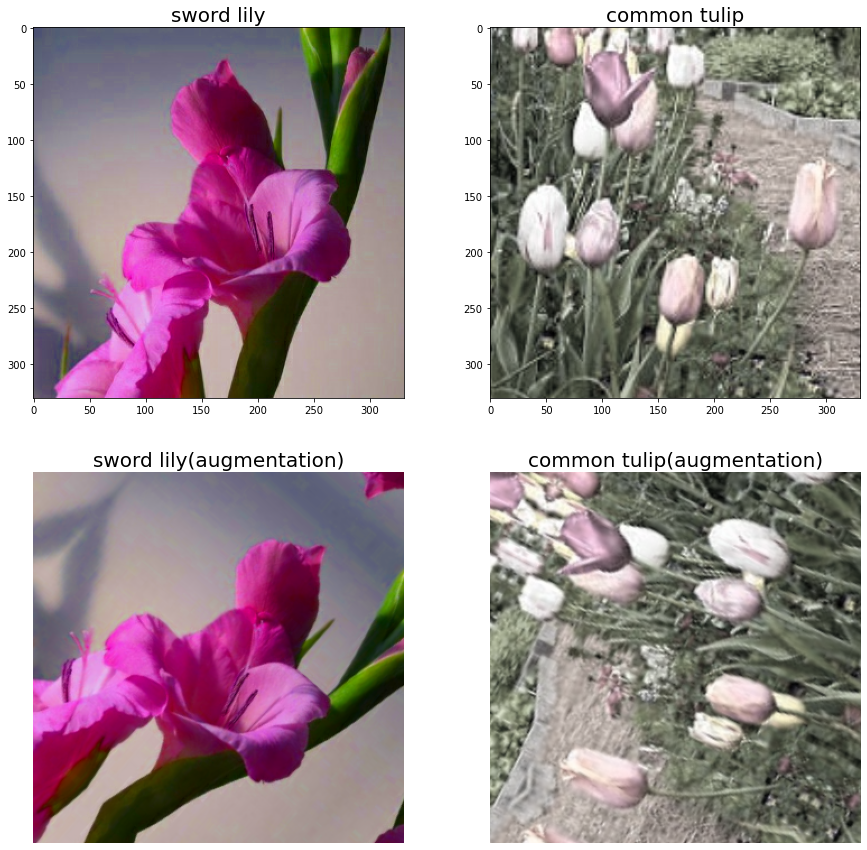

In [29]:
#show the image and the class name from train dataset, and photos with random augmentation is also showed (contrast, saturation, random flip, random rotation)
plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
    augmented_images=data_augmentation(images)
    #print(images.shape, labels.shape)
    for i in range(2):
        #top 2 plots showed original images
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(CLASS[labels[i]], fontsize=20)
        #bottom 2 plots showed augmented images
        ax = plt.subplot(2,2,i+3)
        plt.imshow(augmented_images[i].numpy())
        plt.title(CLASS[labels[i]]+'(augmentation)', fontsize=20)
        plt.axis("off");
plt.savefig('display_augmentation.jpeg')

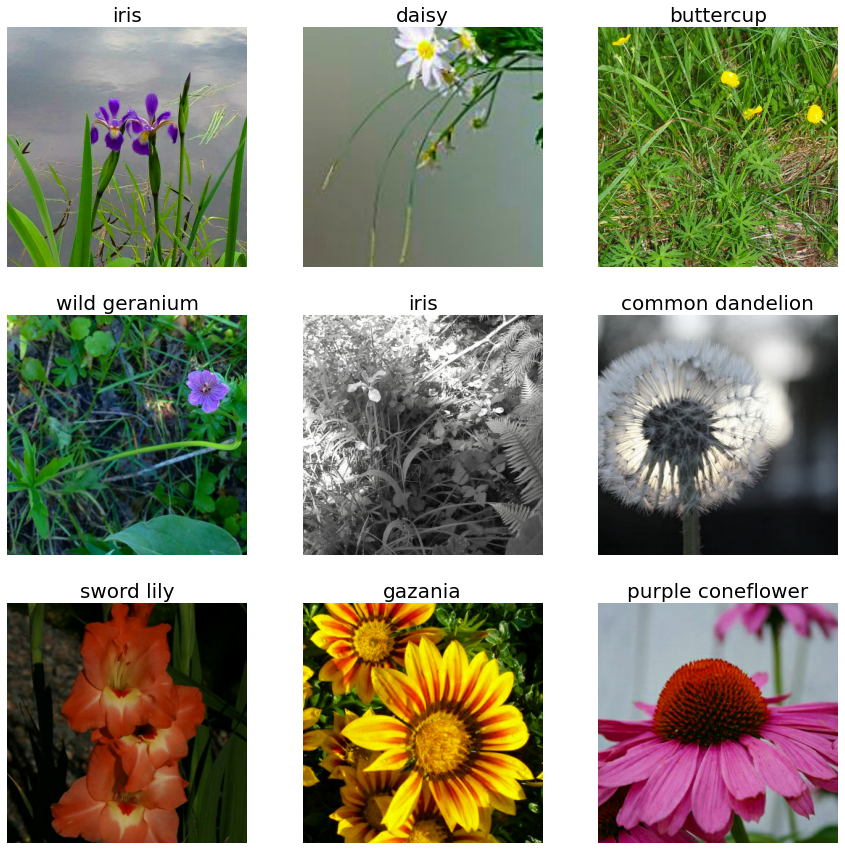

In [31]:
#show the image and the class name from train dataset, and photos with random augmentation is also showed (different contrast and saturation)
plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
    #print(images.shape, labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(CLASS[labels[i]], fontsize=20)
        plt.axis("off");
plt.savefig('train_images.jpeg')

## Modeling
In this section, the project will explore various deep learning algorithms:

1.   Initially, we will use baseline CNN model without fine tuning

2.   Pretrained Xception models 
 > * with/without dropout layer
 > * with/without image augmentation
 > * with various learning rate algorithms (Time-based decay, step-based decay and self-defined learning rate)




### 1. Baseline CNN model

* conv2Ddrop: Conv2D + Maxpooling (3 layers) + Dropout layer with default 'adam'optimizer

#### **Define function to plot accuracy**

In [32]:
#define a function to plot the accuracy as a function of epochs
def plot_accuracy(results):
    plt.plot(results.history['sparse_categorical_accuracy'], label='training accuracy')
    plt.plot(results.history['val_sparse_categorical_accuracy'], label='testing accuracy')
    plt.xlabel('epochs')
    plt.legend();


##### **Conv2D + Maxpooling + Dropout**

1.   Define a function to construct the model with
  * top layer
  * input-defined hidden layers with dropout layer, 
  * flatten and dense layer 
  * output layer
  * compile model 

2.   Initiate the model and fit with train dataset

3. Check accuracy score on train and val dataset












In [97]:
def conv2d_drop_model(first_layer_neurons=32, second_layer_neurons=16, drop_rate=0.2, hidden_layers=5):
    
    #model
    model=Sequential()

    #conv 2d + pooling
    for layer in range(hidden_layers):
        if layer == 0:
            model.add(Conv2D(filters=first_layer_neurons, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(drop_rate))
        #conv2d + pooling
        else:
            model.add(Conv2D(filters=second_layer_neurons, kernel_size=(3,3), activation='relu'))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(drop_rate))

    #flatten and dense
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    
    #output
    model.add(Dense(len(CLASS), activation='softmax'))
    
    #compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [98]:
#instantiate the model
cnn_drop=conv2d_drop_model(hidden_layers=3)

In [ ]:
#define a callbacks for tensorboard
#logs="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1)

In [101]:
#fit the model
drop_results=cnn_drop.fit(train, 
                          validation_data=val, 
                          epochs=6, 
                          #callbacks=tensorboard_callback
                          )

Epoch 1/6
100/100 [==============================] - 205s 2s/step - loss: 3.0037 - sparse_categorical_accuracy: 0.2384 - val_loss: 3.1797 - val_sparse_categorical_accuracy: 0.2174
Epoch 2/6
100/100 [==============================] - 205s 2s/step - loss: 2.8090 - sparse_categorical_accuracy: 0.2793 - val_loss: 3.0951 - val_sparse_categorical_accuracy: 0.2271
Epoch 3/6
100/100 [==============================] - 205s 2s/step - loss: 2.5830 - sparse_categorical_accuracy: 0.3289 - val_loss: 2.9434 - val_sparse_categorical_accuracy: 0.2645
Epoch 4/6
100/100 [==============================] - 205s 2s/step - loss: 2.2941 - sparse_categorical_accuracy: 0.3939 - val_loss: 2.8520 - val_sparse_categorical_accuracy: 0.2799
Epoch 5/6
100/100 [==============================] - 205s 2s/step - loss: 1.8861 - sparse_categorical_accuracy: 0.4937 - val_loss: 2.8759 - val_sparse_categorical_accuracy: 0.2729
Epoch 6/6
100/100 [==============================] - 205s 2s/step - loss: 1.3871 - sparse_categorica

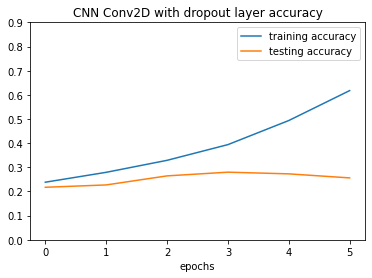

In [102]:
# Plot the accuracy of train and val datasets as a function of epochs

plot_accuracy(drop_results)
plt.title('CNN Conv2D with dropout layer accuracy')
plt.ylim((0,0.9));
plt.savefig('conv2D_w_drop_accuracy.jpeg')

## 2. Imagenet pretrained model + GlobalAveragePooling2D model

* create a function to define a time-based decay learning rate scheduler
* instantiate a pretrained Imagenet model
* instantiate a model to include the pretrained-model and a GlobalAveragePooling model
* fit the model with a learning rate scheduler

### Define a learning rate schedule to decay the learning rate as epoch increases

In [103]:
#define a time-based decay for learning schedule function

#initialize the learning rate and decay 
s_lr=0.001
epochs=10
decay=s_lr/epochs

#define the learning rate schedule function to return a slower learning rate as epoch increases
def lr_schedule_decay(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    return lr*1/(1+decay*epoch)


Learning rate schedule: 0.001 to 0.001, 0.001 


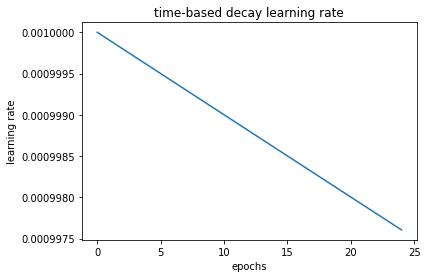

In [ ]:
#plot the time-based decay learning rate as a function of epochs
epochs = [i for i in range(25)]
y = [lr_schedule_decay(x, 0.001) for x in epochs]
plt.plot(epochs, y)
plt.xlabel('epochs')
plt.title('time-based decay learning rate')
plt.ylabel('learning rate')
print(f'Learning rate schedule: {y[0]} to {max(y)}, {round(y[-1], 4)} ')
#plt.savefig('./saved_img/time_lr.jpeg')

### Instantiate a Imagenet pre-trained model and combined with GlobalAveragePooling2D layers

Keras has a collection of pretrained models suitable for deep learning such as VGG16, ResNet, EfficientNet, DenseNet, etc. [link](https://keras.io/api/applications/).

We here chose `tensorflow.keras.applications.xception.Xception` for its relatively high accuracy and smaller in size comparing with others.

To let tensorflow distribute the TPU cores among train and validation, we use `strategy.scope()` on pretrained models.

We will also free the pre_trained model params in the project.

In [104]:
#Instantiate a globalaveragepooling2d model with Xception as pre_trained model

def get_pretrained_model(drop=True, drop_layers=1, drop_rate=0.3, augmentation=False):
    with strategy.scope():
        pretrained_model = tf.keras.applications.xception.Xception(
            weights='imagenet',
            include_top=False , #do not include the first layer
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False #make sure model params in the imagenet is not trianable as it is pretrained
        
        model = tf.keras.Sequential(pretrained_model)

        #if the data_augmentation is True
        if augmentation:
          data_augmentation
        model.add(GlobalAveragePooling2D())
        
        #if drop_layer is True, then we add dropout layer
        if drop:
          for i in range(drop_layers):
            model.add(Dense(1024, activation='relu'))
            model.add(Dropout(drop_rate))
        #else:
          #model.add(Dense(1024, activation='relu'))

        #output layer
        model.add(Dense(len(CLASS), activation='softmax'))

    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
    )
    
    return model

## Define a function to get the model with the following features
* **Optimizer**: use `tf.keras.optimizers` and use the `ExponentialDecay` with pre-defined `initial_learning_rate`, `decay_steps` and `decay_rate`.
* **Image augmentation**: use `layers.RandomRotation` and `layers.RandomFlip` as a layer prior `GlobalAveragePooling2D`
* **Dropout layer**: A choice of whether or not to use drop out layer, and if use, user can define the drop rate.

In [105]:
#Instantiate a time-based decay model with 1 dropout layer without augmentation
time_model = get_pretrained_model(drop_layers=1, drop_rate=0.5, augmentation=False)
#log_dir='logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


#learning rate callbacks
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_decay, verbose=1)

#fit the model
history=time_model.fit(
    train_lr,
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH, 
    callbacks=lr_callback
)




Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
99/99 [==============================] - 48s 318ms/step - loss: 2.4526 - sparse_categorical_accuracy: 0.4359 - val_loss: 1.3816 - val_sparse_categorical_accuracy: 0.6659 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999000574917021.
Epoch 2/25
99/99 [==============================] - 21s 213ms/step - loss: 1.3409 - sparse_categorical_accuracy: 0.6470 - val_loss: 1.0305 - val_sparse_categorical_accuracy: 0.7284 - lr: 9.9990e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.000999700106714659.
Epoch 3/25
99/99 [==============================] - 21s 217ms/step - loss: 1.0797 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.8731 - val_sparse_categorical_accuracy: 0.7783 - lr: 9.9970e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009994003415259673.
Epoch 4/25
99/99 [==============================] - 21s 217ms/step - loss: 


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
99/99 [==============================] - 48s 319ms/step - loss: 2.4587 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.4092 - val_sparse_categorical_accuracy: 0.6296 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999000574917021.
Epoch 2/30
99/99 [==============================] - 21s 215ms/step - loss: 1.3223 - sparse_categorical_accuracy: 0.6453 - val_loss: 1.0190 - val_sparse_categorical_accuracy: 0.7223 - lr: 9.9990e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.000999700106714659.
Epoch 3/30
99/99 [==============================] - 22s 219ms/step - loss: 1.0233 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.8982 - val_sparse_categorical_accuracy: 0.7581 - lr: 9.9970e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009994003415259673.
Epoch 4/30
99/99 [==============================] - 21s 217ms/step - loss: 

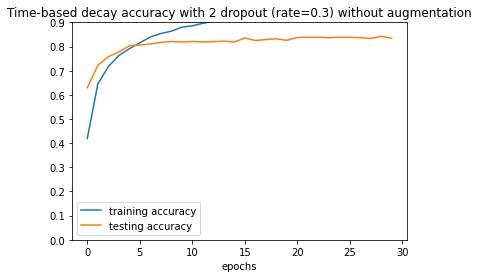

In [106]:
#Instantiate a time-based decay model without augmentation
time_model_2 = get_pretrained_model(drop_layers=2, drop_rate=0.3, augmentation=False)
#log_dir='logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


#learning rate callbacks
#lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_decay, verbose=1)

#fit the model
history_2=time_model_2.fit(
    train_lr,
    validation_data=val,
    epochs=30,
    steps_per_epoch=STEPS_PER_EPOCH, 
    callbacks=lr_callback
)


#plot accuracy
plot_accuracy(history_2)
plt.title('Time-based decay accuracy with 2 dropout (rate=0.3) without augmentation')
plt.ylim((0,0.9));
plt.savefig('time_model_w_2dropouts_accuracy.jpeg')


In [107]:
#Instantiate a time-based decay model without dropout layers
time_model_3 = get_pretrained_model(drop=False, augmentation=False)

lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_decay, verbose=1)

#fit the model
history_3=time_model_3.fit(
    train_lr,
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH, 
    callbacks=lr_callback
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
99/99 [==============================] - 47s 319ms/step - loss: 2.9550 - sparse_categorical_accuracy: 0.3565 - val_loss: 2.0542 - val_sparse_categorical_accuracy: 0.5539 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999000574917021.
Epoch 2/25
99/99 [==============================] - 21s 213ms/step - loss: 1.7265 - sparse_categorical_accuracy: 0.6265 - val_loss: 1.4735 - val_sparse_categorical_accuracy: 0.6864 - lr: 9.9990e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.000999700106714659.
Epoch 3/25
99/99 [==============================] - 21s 216ms/step - loss: 1.3350 - sparse_categorical_accuracy: 0.7042 - val_loss: 1.2239 - val_sparse_categorical_accuracy: 0.7320 - lr: 9.9970e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009994003415259673.
Epoch 4/25
99/99 [==============================] - 22s 218ms/step - loss: 

### Time_based model with augmentation and dropout layer

In [108]:
#instantiate the time-based decay model with augmentation
time_model_aug=get_pretrained_model(drop_layers=1, drop_rate=.5, augmentation=True)

#check model summary and parameters
time_model_aug.summary()

history_aug = time_model_aug.fit(    
    train_lr,    
    validation_data=val,    
    epochs=25,    
    steps_per_epoch=STEPS_PER_EPOCH,    
    callbacks=lr_callback
    )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 11, 11, 2048)      20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 104)               106600    
                                                                 
Total params: 23,066,256
Trainable params: 2,204,776
Non-trainable params: 20,861,480
__________________________________

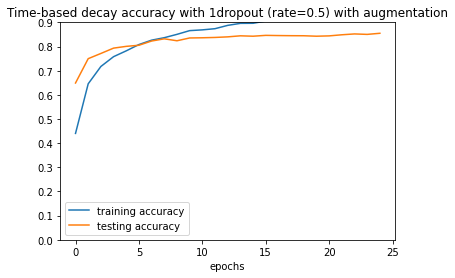

In [109]:
#plot the accuracy
plot_accuracy(history_aug)
plt.title('Time-based decay accuracy with 1dropout (rate=0.5) with augmentation')
plt.ylim((0,0.9));
plt.savefig('time_model_w_1dropout_aug_accuracy.jpeg')

### Time based decay model without dropout layer

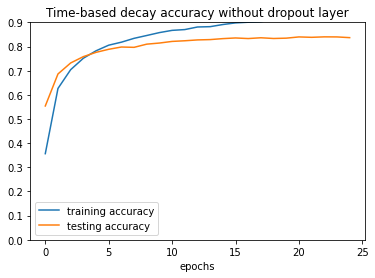

In [110]:
#plot the accuracy
plot_accuracy(history_3)
plt.title('Time-based decay accuracy without dropout layer')
plt.ylim((0,0.9));
plt.savefig('time_model_wo_dropout_accuracy.jpeg')

### Observation on Xception pretrained with time-based decay LR: 
* The choice of Xception pretrained model has improved the accuracy on both train and val significantly.
* Adding dropout layer helps to control overfit, but does not influence val_accuracy significantly.
* Adding two Dense+Dropout layers further control overfit, but did lead to a slight decrease in val_accuracy
* Image augmentation does not improve val_accuracy further.

**Conclusion:**
* Choice of 1 dropout layer with drop rate = 0.5, discard image augmentation layer to reduce model complexity.


## Xception model with step-wise decay learning rate
* Define a decay function for step-decay
* instantiate a Xception pretrained model using `get_pretrained_model()` function
* Fit the model with 1 or 2 dropout layers and compare the performance

Learning rate schedule: 0.001 to 0.001, 0.0 


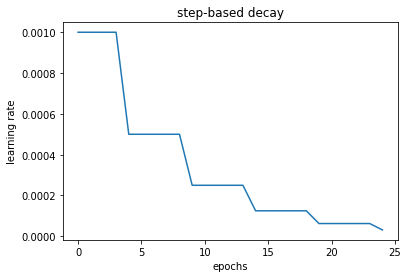

In [33]:
import math
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

rng = [i for i in range(25)]
y = [step_decay(x) for x in rng]
plt.plot(rng, y)
plt.title('step-based decay')
plt.xlabel('epochs')
plt.ylabel('learning rate')
print(f'Learning rate schedule: {y[0]} to {max(y)}, {round(y[-1], 4)} ')
#plt.savefig('step_lr.jpeg')

In [37]:
#Instantiate a Xception model with dropout layer without augmentation
step_model = get_pretrained_model(drop_layers=1, drop_rate=.5)

#Fit the model with step-based decay LR 
history_step = step_model.fit(
    train_lr,
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=lrate
)

83697664/83683744 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


99/99 [==============================] - 48s 326ms/step - loss: 2.4499 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.4082 - val_sparse_categorical_accuracy: 0.6511 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
99/99 [==============================] - 21s 214ms/step - loss: 1.3871 - sparse_categorical_accuracy: 0.6411 - val_loss: 1.0274 - val_sparse_categorical_accuracy: 0.7322 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
99/99 [==============================] - 21s 216ms/step - loss: 1.0714 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.8938 - val_sparse_categorical_accuracy: 0.7756 - lr: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
99/99 [==============================] - 21s 216ms/step - loss: 0.9045 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.8021 - val_sparse_categorical_accuracy: 0.7934 - lr: 0.0010

Epoch 00005: LearningRateSched

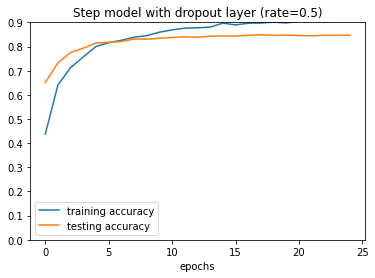

In [38]:
plot_accuracy(history_step)
plt.title('Step model with dropout layer (rate=0.5)')
plt.ylim((0,.9));
plt.savefig('step_w_dropout_accuracy.jpeg')

In [39]:
#Instantiate Xception model with 2 dropout layers
step_model_2 = get_pretrained_model(drop_layers=2, drop_rate=.3, augmentation=True)

#Fit time-based decay model 
history_step_2 = step_model_2.fit(
    train_lr,
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=lrate
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/25
99/99 [==============================] - 48s 319ms/step - loss: 2.4606 - sparse_categorical_accuracy: 0.4239 - val_loss: 1.3585 - val_sparse_categorical_accuracy: 0.6544 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/25
99/99 [==============================] - 21s 216ms/step - loss: 1.3217 - sparse_categorical_accuracy: 0.6463 - val_loss: 1.0191 - val_sparse_categorical_accuracy: 0.7298 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/25
99/99 [==============================] - 21s 217ms/step - loss: 1.0362 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.9135 - val_sparse_categorical_accuracy: 0.7513 - lr: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/25
99/99 [==============================] - 21s 217ms/step - loss: 0.8393 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.8139 - val_s

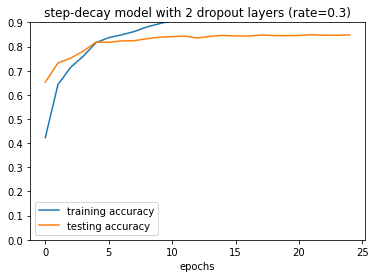

In [ ]:
plot_accuracy(history_step_2)
plt.title('step-decay model with 2 dropout layers (rate=0.3)')
plt.ylim((0,.9));
plt.savefig('step_w_2dropouts_accuracy.jpeg')

**Step-decay learning rate:**
* The model with 1 dropout layer has better overall performance. It has better control on overfit and has higher val accuracy of 85%
* 2 dropout layers slightly decreased val accuracy to 83%

## Xception model with self-defined LR scheduler
* Customerize LR scheduler: Start with slow LR and ramp up after 5 epochs and then exponentially decay
  * It was demonstrated by others that pre-trained models would perform better to have slow initial learning rate, then slowly ramp up as epoches increase, and finally exponentially decay the learning rate at further deep learning.
* We'll going to compare this algorithm with Xception models with time-based decay and step-wise decay.

Learning rate schedule: 0.0001 to 0.004, 0.0002 


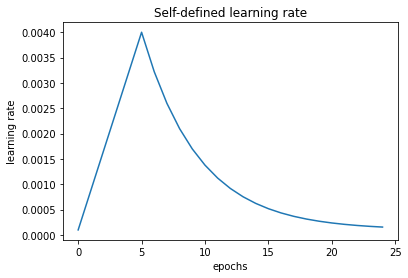

In [111]:
#custom LR scheduler
LR_START= 0.0001
LR_MAX = 0.0005 * strategy.num_replicas_in_sync
LR_MIN= 0.0001
LR_RAMPUP_EPOCHS=5
LR_SUSTAIN_EPOCHS=0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback=tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
plt.title('Self-defined learning rate')
plt.xlabel('epochs')
plt.ylabel('learning rate')
print(f'Learning rate schedule: {y[0]} to {max(y)}, {round(y[-1], 4)} ')
#plt.savefig('./saved_img/lrfn_lr.jpeg')

## Fit self defined LR scheduler pretrained_model

In [112]:
#Instantiate a globalaveragepooling2d model
model_lrfn = get_pretrained_model(drop_layers=1, drop_rate=.5)

In [113]:
#fit the model with lrfn learning rate
history_lrfn=model_lrfn.fit(
    train_lr, 
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=lr_callback
    )


Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/25
99/99 [==============================] - 47s 323ms/step - loss: 3.7668 - sparse_categorical_accuracy: 0.2126 - val_loss: 3.0535 - val_sparse_categorical_accuracy: 0.3481 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008800000000000001.
Epoch 2/25
99/99 [==============================] - 21s 216ms/step - loss: 1.9731 - sparse_categorical_accuracy: 0.5268 - val_loss: 1.1946 - val_sparse_categorical_accuracy: 0.7053 - lr: 8.8000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0016600000000000002.
Epoch 3/25
99/99 [==============================] - 21s 216ms/step - loss: 1.2879 - sparse_categorical_accuracy: 0.6570 - val_loss: 0.9535 - val_sparse_categorical_accuracy: 0.7446 - lr: 0.0017

Epoch 00004: LearningRateScheduler setting learning rate to 0.00244.
Epoch 4/25
99/99 [==============================] - 21s 217ms/step - loss: 1.1006 - sparse_categorical_

In [114]:
#Instantiate a globalaveragepooling2d model with two dropout layers
model_lrfn_2 = get_pretrained_model(drop_layers=2, drop_rate=.3)

#fit the model with lrfn learning rate
history_lrfn_2=model_lrfn_2.fit(
    train_lr, 
    validation_data=val,
    epochs=25,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=lr_callback)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/25
99/99 [==============================] - 48s 322ms/step - loss: 3.7331 - sparse_categorical_accuracy: 0.2119 - val_loss: 2.8467 - val_sparse_categorical_accuracy: 0.3583 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008800000000000001.
Epoch 2/25
99/99 [==============================] - 21s 217ms/step - loss: 1.9090 - sparse_categorical_accuracy: 0.5256 - val_loss: 1.1532 - val_sparse_categorical_accuracy: 0.6967 - lr: 8.8000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0016600000000000002.
Epoch 3/25
99/99 [==============================] - 22s 220ms/step - loss: 1.3149 - sparse_categorical_accuracy: 0.6457 - val_loss: 1.0228 - val_sparse_categorical_accuracy: 0.7223 - lr: 0.0017

Epoch 00004: LearningRateScheduler setting learning rate to 0.00244.
Epoch 4/25
99/99 [==============================] - 21s 217ms/step - loss: 1.1662 - sparse_categorical_

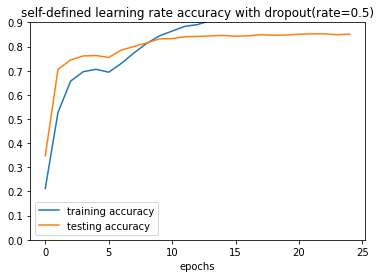

In [115]:
#plot the accuracy
plot_accuracy(history_lrfn)
plt.title('self-defined learning rate accuracy with dropout(rate=0.5)')
plt.ylim((0,0.9));
plt.savefig('lrfn_w_dropout_accuracy.jpeg')

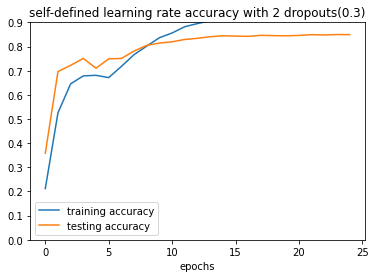

In [116]:
plot_accuracy(history_lrfn_2)
plt.title('self-defined learning rate accuracy with 2 dropouts(0.3)')
plt.ylim((0, 0.9));
plt.savefig('lrfn_w_2dropouts_accuracy.jpeg')

## Compare learning algorithm impacts on val accuracy

In [41]:
#define a function to plot only the val accuracy
def compare_val_acc(history_dict):
    for key, value in history_dict.items():
      plt.plot(value.history['val_sparse_categorical_accuracy'], label=key)
      plt.xlabel('epochs')
      #plt.title(f'{key} model accuracy over epochs')
      plt.legend();

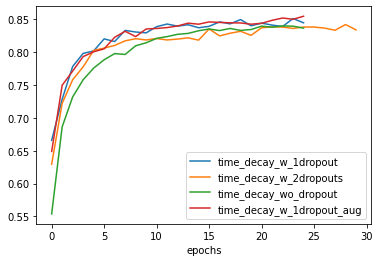

In [119]:
#create a dictionary with all the model results as values and a description of the model as keys.
history_dict={
    #'lrfn_w_1dropout': history_lrfn, 
    #'lrfn_w2_2dropouts': history_lrfn_2,
    'time_decay_w_1dropout':history, 
    'time_decay_w_2dropouts':history_2,
    'time_decay_wo_dropout':history_3,
    'time_decay_w_1dropout_aug':history_aug,
    #'step_decay_w_1dropout': history_step,
    #'step_decay_w_2dropout2': history_step_2
    }

#plot the val accuracy of time-based decay with 3 varying parameters: 1 dropout, 2 dropouts and with image augmentation
compare_val_acc(history_dict)
plt.savefig('time_decay_comparison.png')

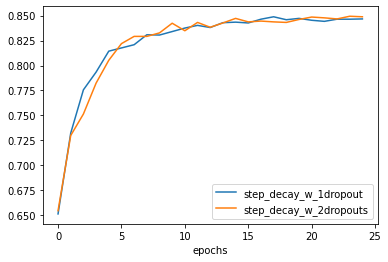

In [120]:
#plot the val accuracy of step-wise decay with 1 and 2 dropout layers
history_dict={
    #'lrfn_w_1dropout': history_lrfn, 
    #'lrfn_w2_dropouts': history_lrfn_2,
    # 'time_decay_w_1dropout':history, 
    # 'time_decay_w_2dropouts':history_2,
    # 'time_decay_wo_dropout':history_3,
    # 'time_decay_w_1dropout_aug':history_aug,
    'step_decay_w_1dropout': history_step,
    'step_decay_w_2dropouts': history_step_2
    }
compare_val_acc(history_dict)

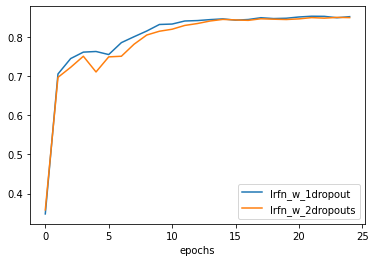

In [121]:
#plot the val accuracy of step-wise decay with 1 and 2 dropout layers
history_dict={
    'lrfn_w_1dropout': history_lrfn, 
    'lrfn_w_2dropouts': history_lrfn_2,
    # 'time_decay_w_1dropout':history, 
    # 'time_decay_w_2dropouts':history_2,
    # 'time_decay_wo_dropout':history_3,
    # 'time_decay_w_1dropout_aug':history_aug,
    # 'step_decay_w_1dropout': history_step,
    # 'step_decay_w_2dropouts': history_step_2
    }
compare_val_acc(history_dict)
plt.savefig('lrfn_accuracy_comparison.png')

## To check the impact of different learning rate algorithms on validation accuracy
* Time-based decay
* Step_based decay
* self-defined LR decay: lrfn-decay

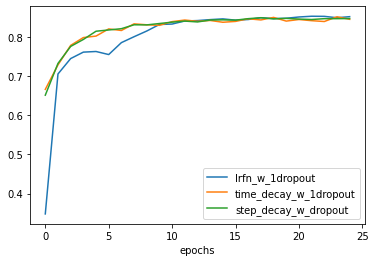

In [123]:
history_dict={
    'lrfn_w_1dropout': history_lrfn, 
    #'lrfn_w2_dropouts': history_lrfn_2,
    'time_decay_w_1dropout':history, 
    #'time_decay_wo_dropout':history_2,
    #'time_decay_w_1dropout_aug':history_aug,
    'step_decay_w_dropout': history_step,
    #'step_decay_w_2dropout2': history_step_2
    }
compare_val_acc(history_dict)
plt.savefig('LR_algorithm_comparison.jpeg')

## Model conclusion

All pretrained Xception models have significant better val accuracy than baseline CNN model.
This project further investigated the impact of the following hyper parameters on Xception model performance: Dropout layer, additional image augmentation, different learning rate algorithms(Time-based, Step-wise and Self-defined LR decay).
* The **best val accuracy score** is 85% with step-wise decay with 1 dropout layer(drop_rate = 0.5).


* **DROPOUT LAYER(control overfit):** 
  * In general, the presence of 1 dropout layer do not influence the overall accuracy on val, but it does help to control overfit. The same observation on all learning algorithms
* **ADDITIONAL IMAGE AUGMENTATION(no impact):** 
  * The presence of additional image augmentation does not impact the val accuracy nor train accuracy; therefore is not used for step-wise decay and lrfn-decay models.
* **LR DECAY ALGORITHMS(not a big leverage):**
  * step-wise and lrfn-decay learning algorithms have slightly better performance on validation accuracy than time-based decay after 25 epochs
  * step-wise decay achieves optimum val accuracy at less epochs than lrfn LR decay.


## Make a prediction on validation dataset

In [43]:
#make a prediction and assign the highest proba to the prediction array.
val_proba = step_model.predict(val)
#probability of step_model_2
val_proba_2 = step_model_2.predict(val)

#assign the prediction of maximum probaility based on the predictions from 2 models
val_pred=np.argmax((val_proba+val_proba_2)/2, axis=-1)


# Display the image from predictions on validation dateset
* if prediction is **correct**, image title has **label(OK)**
* if prediction is **incorrect**, image title showed **Pred** and **True** labels.

### Define functions to display predicted images and to display test images with class name

In [ ]:
#define a function to show image of prediction in validation dataset
def show_image(take_num, val_prediction):
    plt.figure(figsize=(15,15))
    for images, labels in val.take(take_num):
        print(images.shape, labels.shape)
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy())
            #if the prediction matches with the val label, confirm it is okay
            if labels[i]==val_prediction[(take_num-1)*BATCH_SIZE+i]:
                confirmation='(OK)'
            #otherwise, assign the prediction as incorrect
            else:
                true_label=CLASS[labels[i]]
                confirmation=f'\n True: {true_label}'
            plt.title(f'Pred: {CLASS[val_prediction[(take_num-1)*BATCH_SIZE+i]]}'+confirmation, fontsize=12)
            plt.axis("off");
    #save the image as an option 
    #plt.savefig(f'./saved_img/validation_img_{take_num-1}.jpeg')
    
    
#define a function to show image for unlabelled test dataset
def get_test_image(take_num, prediction):
    plt.figure(figsize=(15, 15))
    for images, labels in test.take(take_num):
        print(images.shape, labels.shape)
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy())
            #if the prediction matches with the val label, confirm it is okay
            plt.title(CLASS[prediction[(take_num-1)*BATCH_SIZE+i]], fontsize=18)
            plt.axis("off");

(128, 331, 331, 3) (128,)


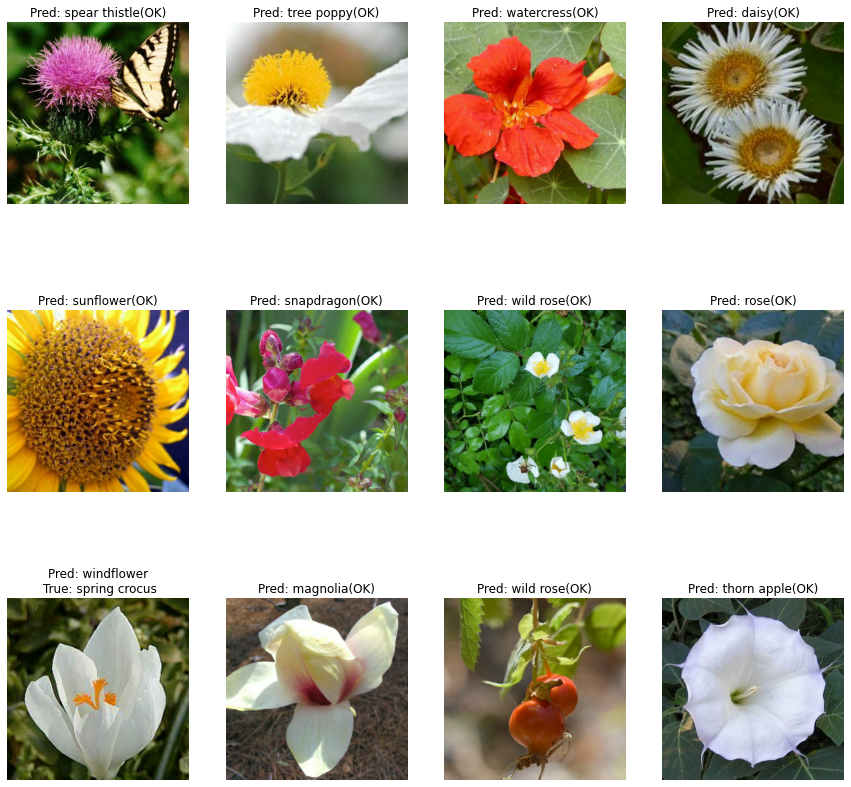

In [ ]:
show_image(1,val_pred)
plt.savefig('val_pred_1.jpeg')

(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


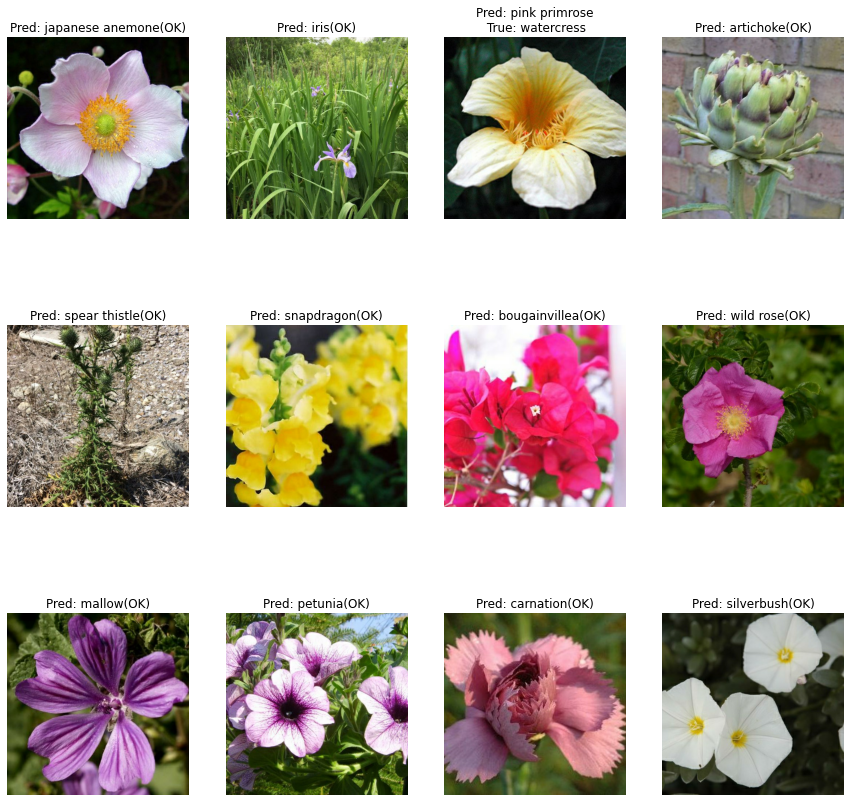

In [ ]:
show_image(2,val_pred)
plt.savefig('val_pred_2.jpeg')

## Save actual labels and prediction labels into a `csv` file
* unpack images and labels from val
* save labels for all images into a list
* save the labels and predictions into a dictionary
* convert the dictionary into a dataframe 
* function return to the dataframe

In [82]:
import pandas as pd
def combine_label_preds(data, pred):
  #intiate an empty list to store labels
  labels_list=[]

  #loop through all images in labelled dataset and append the labels to `labels_list`
  for images, labels in data.take(30):
    labels_list.append(labels.numpy())

  # get the 2d array into 1d array
  label_array = np.array(labels_list).flatten()

  #verify the shape of label matches with prediction
  print(f'The shape of actual is {label_array.shape}\nThe shape of prediction is {pred.shape}')

  #create a dictionary to store both actual labels and predictions
  dictionary = {'actual': label_array, 'prediction':pred}

  #combine into a dataframe
  pred_df = pd.DataFrame(dictionary)

  return pred_df


In [83]:
#get the validation prediction and actual labels
val_pred =combine_label_preds(val, val_pred)

The shape of actual is (3712,)
The shape of prediction is (3712,)


In [84]:
#check the first 5 rows of the actual and prediction dataframe
val_pred.head()

actual  prediction
0      13          13
1      88          88
2      53          53
3     103         103
4      66           0

In [85]:
#save the dataframe into a csv file
val_pred.to_csv('val_pred.csv')

## Define a function to plot Confusion Matrix for a given batch in validation dataset

In [96]:
flower_labels =[CLASS[item] for item in val_pred['actual']]
flower_labels[:5]

['spear thistle', 'watercress', 'sunflower', 'wild rose', 'spring crocus']

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


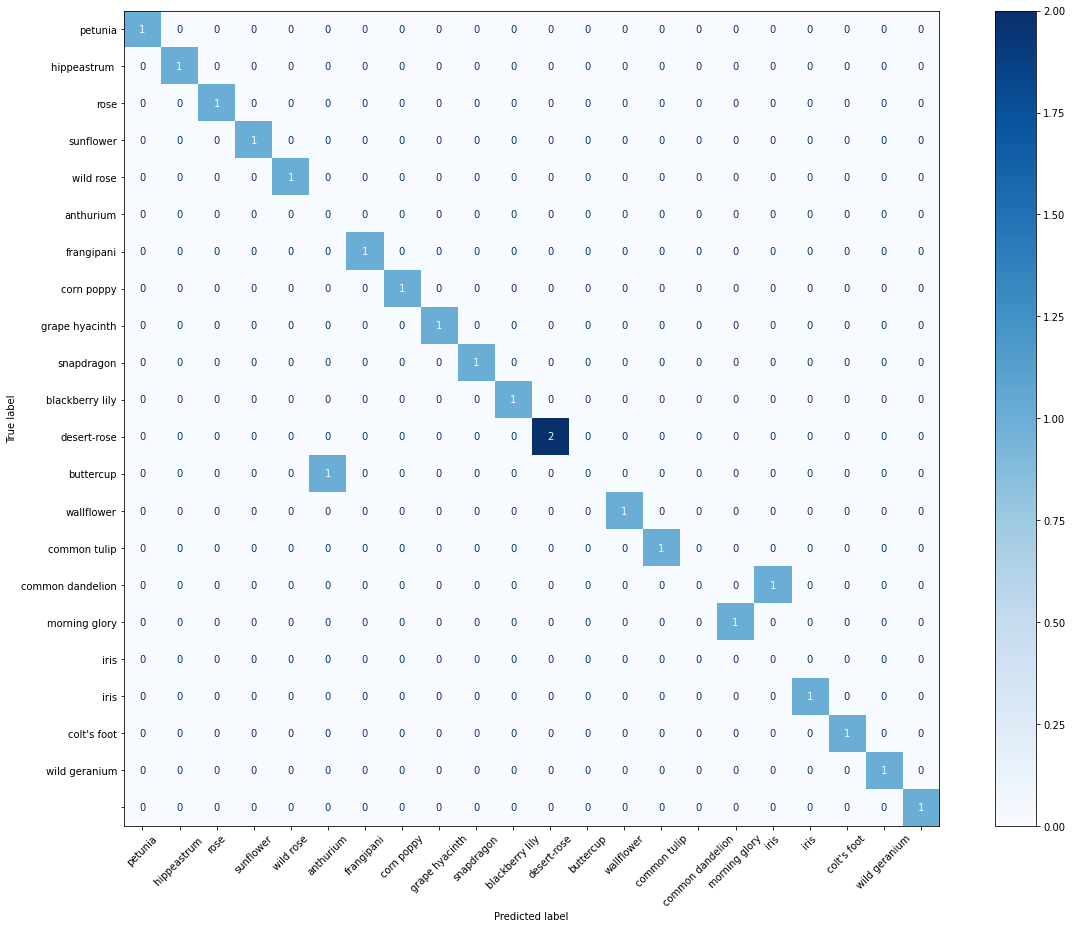

In [95]:
#create a confusion matrix with the first 20 items
cm=confusion_matrix(val_pred['actual'][20:41],  val_pred['prediction'][20:41])

#get the first 20 class labels
display_labels = flower_labels[20:41]

#print the confusion matrix
print(cm)

#create a confusionmatrixdisplay object
disp = ConfusionMatrixDisplay(cm,display_labels=display_labels)

#plot the confusion matrix
fig, ax = plt.subplots(figsize=(20,15))
disp.plot(ax=ax, cmap='Blues')
ax.set_xticklabels(display_labels, rotation=45);

#save the confusion matrix
plt.savefig('confusion_matrix.jpeg')

# Conclusions

* This Capstone demonstrated how to ultilize Tensor Processing Unit (TPU), a distribution strategy that TensowFlow specialized in deep learning tasks by powerful TPU cores.
* Xception pretrained model has significantly better performance than baseline CNN model(without fine-tuning).
  * Resources suggested that if we can play with the optmizer and learning rate, there is a chance we can improve the CNN model accuracy from 23%; however, it is interesting to learn that there are fundamental difference between Global Aaverage Pooling and fully connected layer as in CNN.[resources]('https://codelabs.developers.google.com/codelabs/keras-flowers-tpu#11')


* Fine-tuning parameters and augmentation are utilized in the deep learning using pre-trained Xception models with different learning rate scheduler and dropout layer.

|Model nomenclature|pretrain_model|Dropout_layers|Image_augmentation|LR algorithms|Overfit|Val_accuracy|
|---|---|---|---|---|---|---|
|conv2Ddrop|na|1|Y|adam default|extremely overfit|23%|
|time_model_aug|Xception|1|Y|Time-decay_LR|slightly overfit|85%|
|time_model|Xception|1|N|Time-decay LR|greatly overfit|84%|
|time_model_3|Xception|0|N|Time-decay LR|extremely overfit|83%|
|time_model_2|Xception|2|N|Time-decay LR|greatly overfit|83%|
|step_model|Xception|1|N|Step-wise decay LR|slightly overfit|85%|
|step_model_2|Xception|2|N|Step_wise decay LR|greatly overfit|85%|
|lrfn_model|Xception|1|N|Self-defined decay LR|slightly overfit|85%|
|lrfn_model_2|Xception|2|N|Self-defined decay LR|greatly overfit|85%|

## Summary of model performances
with self-defined learning rate schedulers were explored to construct deep learning model for multiclass classification. All LR algorithms have similar val accuracy (83-85%), but models with time_based decay and step_wise decay able to reach optimum val performance at less epochs than lrfn_decay.
* **dropout_layer**: 1 dropout layer with drate_rate = 0.5 is the best params
* **image_augmentation**: additional image_augmentation such as random rotation and random flip does not further impact on the validation accuracy.
* **learning rate**: time-based and step-wise decay both worked similar, lrfn_decay has lower val_performance at less epochs (epochs <10). 



